# ICOLCAP.CL Price Analysis

This notebook loads `ICOLCAP.CL` from the SQLite database and plots historical close price and volume.

In [1]:
import sqlite3
from pathlib import Path

import pandas as pd
import matplotlib.pyplot as plt

import plotly.graph_objects as go
from plotly.subplots import make_subplots

In [2]:
TICKER = "ICOLCAP.CL"
candidate_paths = [Path("stock_data.db"), Path("../stock_data.db")]
db_path = next((p for p in candidate_paths if p.exists()), None)

if db_path is None:
    raise FileNotFoundError("Could not find stock_data.db in current or parent directory.")

db_path

PosixPath('../stock_data.db')

In [3]:
query = """
SELECT date, open, high, low, close, adj_close, volume, dividends, stock_splits
FROM ticker_prices
WHERE ticker = ?
ORDER BY date
"""

with sqlite3.connect(db_path) as conn:
    df = pd.read_sql_query(query, conn, params=(TICKER,), parse_dates=["date"])

if df.empty:
    raise ValueError(f"No rows found for {TICKER}.")

df.head()

,date,open,high,low,close,adj_close,volume,dividends,stock_splits
0,2013-05-02,17040.0,17041.0,17010.0,17040.0,11223.926758,342950.0,0.0,0.0
1,2013-05-03,17045.0,17170.0,17045.0,17045.0,11227.221680,169086.0,0.0,0.0
2,2013-05-06,16910.0,17011.0,16910.0,16910.0,11138.302734,40234.0,0.0,0.0
3,2013-05-07,16978.0,17017.0,16978.0,16978.0,11183.088867,700000.0,0.0,0.0
4,2013-05-08,16796.0,16960.0,16796.0,16796.0,11063.211914,405000.0,0.0,0.0


In [4]:
df["close_50ma"] = df["close"].rolling(50).mean()
df["close_200ma"] = df["close"].rolling(200).mean()

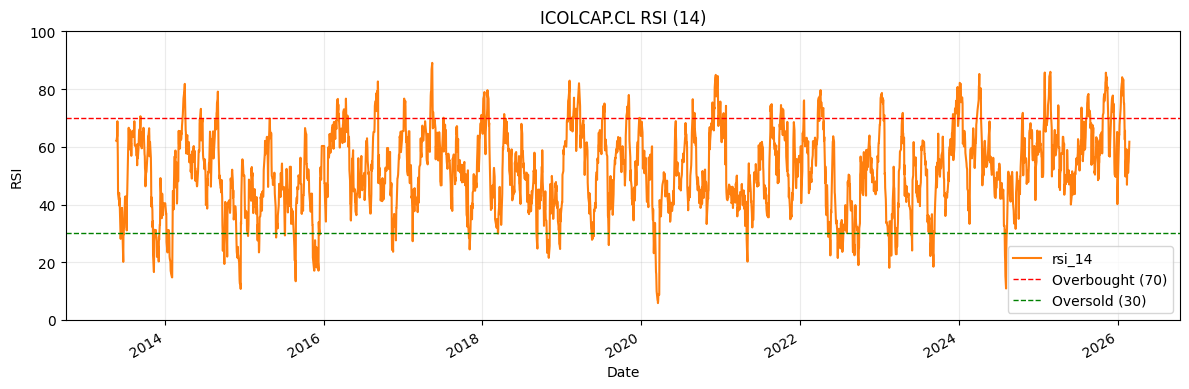

In [5]:
# RSI (14) with overbought/oversold limits
delta = df['close'].diff()
gain = delta.clip(lower=0)
loss = -delta.clip(upper=0)
avg_gain = gain.ewm(alpha=1/14, min_periods=14, adjust=False).mean()
avg_loss = loss.ewm(alpha=1/14, min_periods=14, adjust=False).mean()
rs = avg_gain / avg_loss
df['rsi_14'] = 100 - (100 / (1 + rs))

ax = df.plot(x='date', y='rsi_14', figsize=(12, 4), legend=False, color='tab:orange')
ax.axhline(70, color='red', linestyle='--', linewidth=1, label='Overbought (70)')
ax.axhline(30, color='green', linestyle='--', linewidth=1, label='Oversold (30)')
ax.set_ylim(0, 100)
ax.set_title(f'{TICKER} RSI (14)')
ax.set_xlabel('Date')
ax.set_ylabel('RSI')
ax.grid(alpha=0.25)
ax.legend()
plt.tight_layout()
plt.show()

In [7]:
# Interactive Plotly chart (Price + Volume)
fig = make_subplots(specs=[[{'secondary_y': True}]])

fig.add_trace(go.Scatter(x=df['date'], y=df['close'], name='Close', line={'width': 2}), secondary_y=False)
fig.add_trace(go.Scatter(x=df['date'], y=df['close_50ma'], name='50-day MA', line={'width': 1.5}), secondary_y=False)
fig.add_trace(go.Scatter(x=df['date'], y=df['close_200ma'], name='200-day MA', line={'width': 1.5}), secondary_y=False)

fig.add_trace(go.Bar(x=df['date'], y=df['volume'], name='Volume', opacity=0.25), secondary_y=True)

fig.update_layout(
    title=f'{TICKER} Close Price and Volume (Plotly)',
    xaxis_title='Date',
    yaxis_title='Price',
    legend={'orientation': 'h', 'yanchor': 'bottom', 'y': 1.02, 'xanchor': 'left', 'x': 0},
    bargap=0,
)
fig.update_yaxes(title_text='Volume', secondary_y=True)
fig.show()

In [8]:
# Interactive Plotly chart (RSI)
fig = go.Figure()
fig.add_trace(go.Scatter(x=df['date'], y=df['rsi_14'], name='RSI (14)', line={'color': 'orange'}))
fig.add_hline(y=70, line_dash='dash', line_color='red')
fig.add_hline(y=30, line_dash='dash', line_color='green')
fig.update_layout(title=f'{TICKER} RSI (14) (Plotly)', xaxis_title='Date', yaxis_title='RSI')
fig.update_yaxes(range=[0, 100])
fig.show()

In [9]:
summary = {
    "rows": len(df),
    "start_date": df["date"].min().date(),
    "end_date": df["date"].max().date(),
    "latest_close": float(df["close"].iloc[-1]),
}
summary

{'rows': 3085,
 'start_date': datetime.date(2013, 5, 2),
 'end_date': datetime.date(2026, 2, 23),
 'latest_close': 24245.0}